# Exploration

Afin de pouvoir choisir les meilleurs modèles et prétraitements à effectuer, il est intéressant de se faire une idée de diverses propriétés des données. Les graphiques offre un support intuitif aux observations effectuées.

Le jeu de données utilisé est ilot1.all.csv, échantilloné sur 1 minute avec preproc.py.


Affichage des distributions de chaque capteurs, de leurs corrélations (entre eux) et autocorrélation (avec eux décalés dans le temps), et des centroïdes résultant de k-means sur les time series.
Fait avec ilot1.all.csv, preprocessed avec moyenne 1min.

Je suis pas sur que les visualisations soient bien utiles. Par contre, deux trois trucs que j'ai utilisé vont surement pouvoir resservir :
    - groupby et fillna/dropna, interpolate/scipy.interp1d : pour mettre en fenêtres et "assainir" un peu les données des nan (voir plot_windows)
    - tslearn : metrics, reduction de dimension (sax/paa(cf conférence)), 2-3 classifiers

## Code

On utilise plusieurs bibliothèques : 
 - numpy, scipy, pandas, matplotlib : classiques
 - seaborn : visualisation de jeu de données
 - tslearn : "surcouche" à sklearn pour les séries temporelles

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns

import statsmodels.api as sm

from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

Initialisation des variables, chargement du fichier (commenter nrows=x pour prendre tout le fichier), description basique.

In [2]:
path = "../data/"
prep_path = "../data/preprocessed/"
path_parts = path+"parts/"
file_names = [
    'All-All-2017-09-01_2018-09-01.csv',
    'neocampus.lite.csv'
]

file_name = prep_path+"ilot1.all.prep.csv"

# Running this with the whole file is pretty long.
df = pd.read_csv(file_name, delimiter=';')#, nrows=5000)
column_names = [
    "time",
    "",
    "value",
    "time",
    "unit",
    "location"
]

print(df.isnull().any(axis=1).sum(), "rows with nan.")

# Drop rows with missing values.
#df.dropna(inplace=True)

# Rename the timestamp column.
df.rename(columns = {df.columns[0]:"time"}, inplace = True)
#df['time'] = pd.to_datetime(df['time'], unit='m')

print(df.head())
print("dataframe :", df.shape)

940 rows with nan.
       time    co2   hum         lum   temp  confort
0  25085453  357.0   NaN  813.000000  22.93      4.5
1  25085454  381.0  42.0  819.333333  23.00      4.8
2  25085455  344.0  42.0  773.666667  22.48      4.8
3  25085456  338.0  42.0  778.000000  22.83      4.8
4  25085457  351.0  43.0  821.000000  22.76      4.9
dataframe : (425454, 6)


Affichage des valeurs de chaque capteur sur toutes les observations, ainsi que de la distribution de ces valeurs.

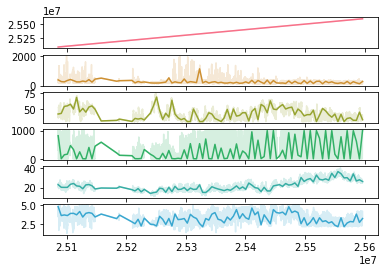

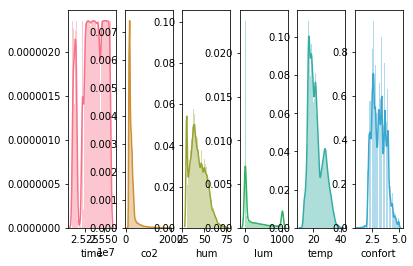

In [61]:
def plot_distributions(df):
    palette = sns.color_palette("husl", 8)
    x = df[df.columns[0]].interpolate()
    interp_x = np.linspace(np.min(x), np.max(x), 100)
    # Plot the values for each sensor, with interpolation.
    #fig = plt.figure()
    for i, col in enumerate(df.columns):
        ax = plt.subplot(len(df.columns), 1, i+1)
        
        y = df[df.columns[i]].interpolate()
        f = interp1d(x, y, kind='slinear')
        interp_y = f(interp_x)
        plt.plot(x, y, alpha=0.2, color=palette[i])
        plt.plot(interp_x, interp_y, alpha=1, color=palette[i])
    plt.show()
        
    
    # Plot distribution.
    for i, col in enumerate(df.columns):
        ax = plt.subplot(1, len(df.columns), i+1)
        sns.distplot(df[df.columns[i]].interpolate(), color=palette[i]) 
    plt.show()

# Drop rows with nan to make the plotting functions work.
plot_distributions(df.dropna())

### Corrélations et autocorrélations
L'autocorrélation d'une variable est sa corrélation avec elle-même, décalée d'un certain temps. Un diagramme d'autocorrélation indique la valeur de ce coefficient selon le délai appliqué.

Si on observe une oscillation régulière de ce coefficient, cela indique la présence d'une saisonnalité/périodicité dans les séries temporelles. Ici, on voit très bien le cycle jour/nuit, mais on observe aussi d'autres cycles plus long (plot pour la température).

Dans tous les cas on en déduit que nos données présentent des "cycles" et que notre modèle devra prendre cela en compte, d'une manière ou d'une autre.

La matrice de corrélation nous montre deux choses :
 - le taux de co2 et la luminosité sont corrélés (respiration+éclairage ?)
 - le confort et le taux de co2 sont inversement corrélés (un peu) : on aurait tendance à penser que les conditions environnementales lorsque le co2 est élevé (et donc des humains présent) seraient bonnes, mais on voit ici que c'est l'inverse. Pourquoi ?

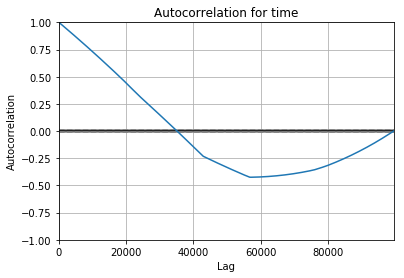

Looks weird...


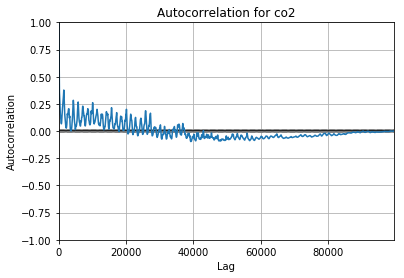

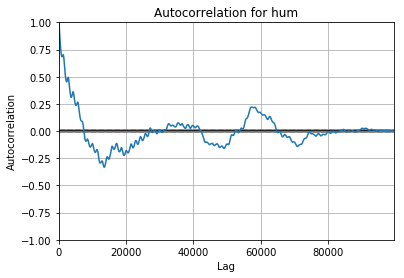

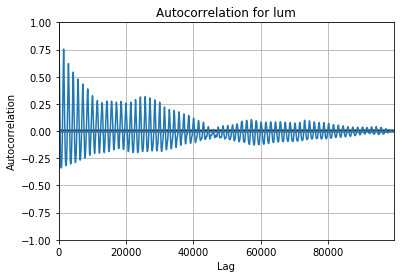

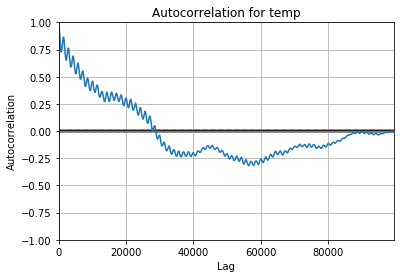

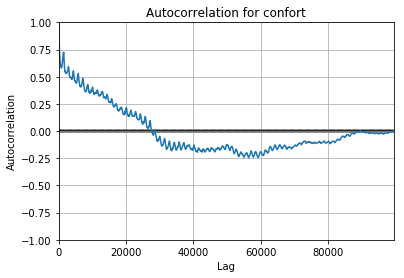

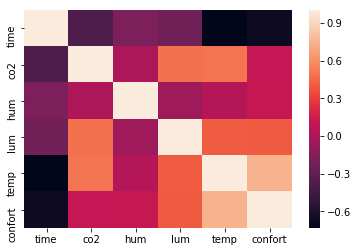

In [62]:
def plot_correlations(df):
    for i, col in enumerate(df.columns):
        #ax = plt.subplot(1, len(df.columns), i+1)
        
        # Plot autocorrelation of the variable.
        pd.plotting.autocorrelation_plot(df[df.columns[i]].interpolate())
        plt.title("Autocorrelation for "+col)
        plt.show()
        if i==0:
            print("Looks weird...")
    #plt.legend()
    #plt.show()

    # Plot correlation between sensors.
    sns.heatmap(df.corr())
    plt.show()

# Computes autocorrelation for each column of a df, with lag.
def df_autocorr(df, lag=1):
    return list(map(
        lambda x: x.autocorr(lag=lag),
        [df[df.columns[i]] for i in range(len(df.columns))]
    ))

plot_correlations(df.iloc[:100000].dropna())

# Décomposition saisonale

Avec une décomposition saisonale, on peut observer deux composantes d'une série : la tendance générale et les "périodes" (ce qui se répète). En ajoutant les deux, on obtient un modèle de notre série temporelle (il est probable que ce soit plus compliqué que ça). Il s'avère que ce modèle reflète bien l'allure générale de la série, mais ne s'adapte pas aux conditions actuelles, ce qui le rend peu efficace pour la prédiction de séries contenant du bruit (ce qui est le cas ici). Un modèle performant devra donc prendre en compte le passé proche, et non juste les données d'apprentissage.

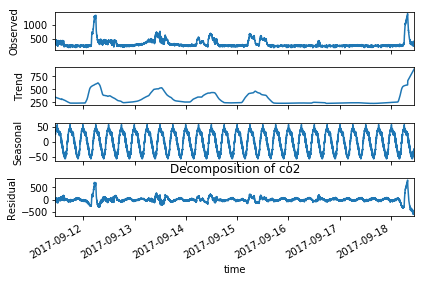

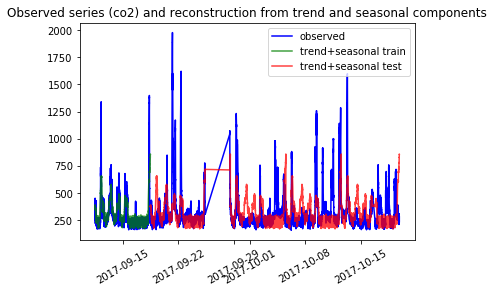

Metrics (normalized)
MAE train : 0.05222164469787017
MSE train : 0.008506759601931688
MAE test : 0.0951557056102632
MSE test : 0.024708143946224972


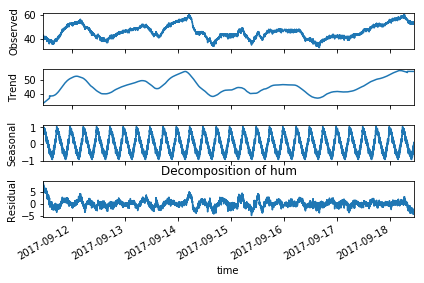

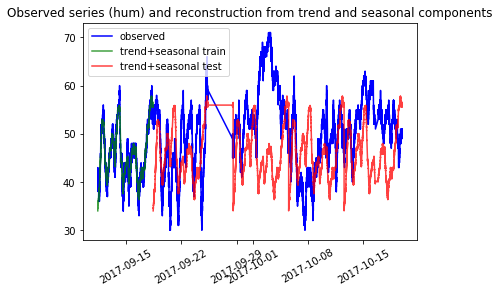

Metrics (normalized)
MAE train : 0.0367471811541543
MSE train : 0.002569110348432138
MAE test : 0.30889758071070406
MSE test : 0.14791346760456223


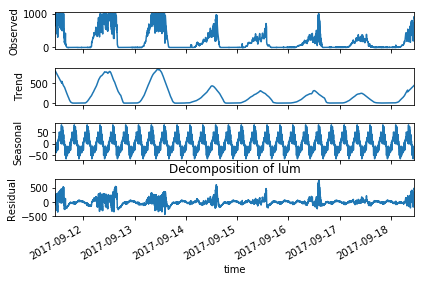

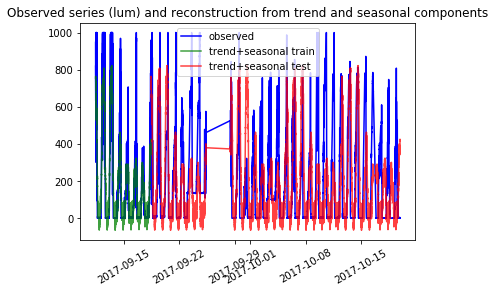

Metrics (normalized)
MAE train : 0.07429603945456362
MSE train : 0.013609198013046341
MAE test : 0.18976767501233893
MSE test : 0.07062813844239132


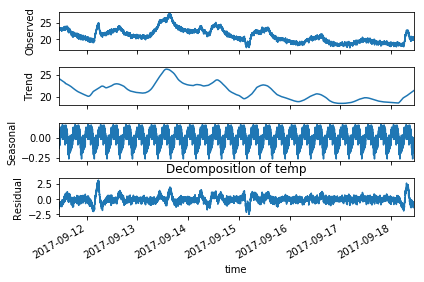

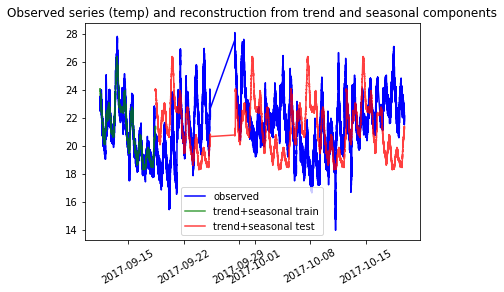

Metrics (normalized)
MAE train : 0.036624280299188655
MSE train : 0.002812663231193272
MAE test : 0.2254771467731382
MSE test : 0.0763556435010664


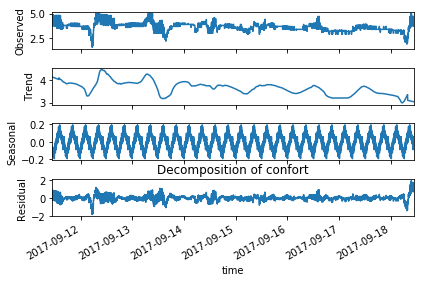

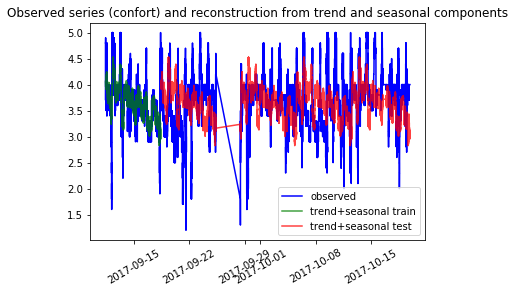

Metrics (normalized)
MAE train : 0.05567345289182913
MSE train : 0.007942253853971015
MAE test : 0.12903400834377252
MSE test : 0.027361768913986652


In [11]:
def seasonal_decomposition(df, column, freq, size, nb_windows):
    
    data = df.copy()
    
    # Convert the index to datetime. (otherwise it is the number of minutes since unix time)
    data.index = pd.to_datetime(data['time'], unit='m')
    data = data.iloc[:size,1:].dropna()
    data = data.iloc[:-(len(data)%nb_windows)]

    
    X_train = data.iloc[:len(data)//nb_windows]
    X_test = data.iloc[len(data)//nb_windows:]
    
    
    X_min, X_range = X_train.min(), X_train.max()-X_train.min()
    def norm(arr, col):
        return (arr-X_min[col])/X_range[col]

    for col in data.columns:
        decomposition = sm.tsa.seasonal_decompose(X_train[col], freq=freq, model='additive', extrapolate_trend='freq')
        decomposition.plot()
        plt.title("Decomposition of {}".format(col))
        plt.show()
        
        y = decomposition.trend + decomposition.seasonal
        y_preds = np.repeat(y[:, np.newaxis], nb_windows-1, axis=-1).flatten(order='F')

        plt.plot(data.index, data[col], c='blue', label="observed")
        plt.plot(data.index[:X_train.shape[0]], y, c='green', label="trend+seasonal train", alpha=0.75)
        
        plt.plot(data.index[X_train.shape[0]:], y_preds, c='red', label="trend+seasonal test", alpha=0.75)
        #plt.plot(decomposition2.trend.index, decomposition2.trend+decomposition2.seasonal
        #         , c='green', label="trend+seasonal 2", alpha=0.75)
        plt.legend()
        plt.title("Observed series ({}) and reconstruction from trend and seasonal components".format(col))
        plt.xticks(rotation=30)
        plt.show()
        
        print("Metrics (normalized)")
        print("MAE train :", np.abs((norm(X_train[col], col) - norm(y, col))).mean())
        print("MSE train :", ((norm(X_train[col], col) - norm(y, col))**2).mean())
        
        print("MAE test :", np.abs((norm(X_test[col].values, col) - norm(y_preds, col))).mean())
        print("MSE test :", ((norm(X_test[col].values, col) - norm(y_preds, col))**2).mean())
        
        
# freq=number of minutes of the windows considered
# size = amount of data from df to use (decrease to get clearer plots)
# nb_windows = similar to test_size in split() : nb_windows=x => training on 1/xth of the data, test on the rest
seasonal_decomposition(df, 'temp', freq=60*6, size=60*24*7*5, nb_windows=5)

### k-means sur TS
Les centroïdes issus d'un apprentissage avec k-means représentent des observations types. Si l'on applique cela à des séries temporelles, on peut avoir un aperçu des séries types, et donc de la manière dont évolue généralement le système.

Les observations sont groupées par fenêtres de length unités de temps, puis assinies. Ces fenêtres sont ensuite utilisées par k-means, et l'on peut ensuite afficher les centroïdes ((en rouge) et les observations associées (en noir, transparent).

L'assainissement mentionné consiste à remplacer les valeurs manquantes par la moyenne dans la fenêtre, et si aucune valeur n'est présente pour cette colonne, par la moyenne globale. Ce procédé pourrait être amélioré (cela vaut-il le coup de garder une série si aucune valeur d'une des colonnes n'est présente ?) et accéléré (très long actuellement).

L'opacité autour de la série temporelle du centroïde traduit le nombre d'observations associées au cluster. On observe une disparité dans le nombre de séries de chaque "type" : les séries "stables" sont bien plus nombreuses que celles qui évoluent. On peut craindre un modèle qui prédit ces séries stables tout le temps et qui obtiendrait de bon scores avec une métrique basique.

Les oscillations que l'on observe avec de "petites" fenêtres (60min par ex) sont dues à la résolution du fichier (1min).

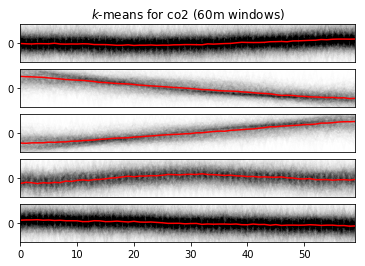

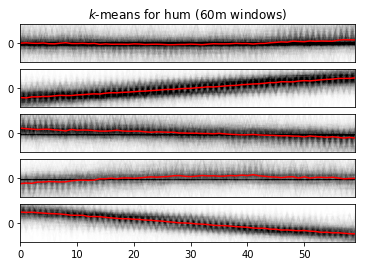

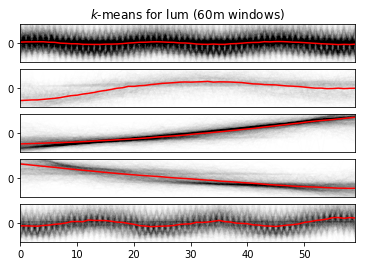

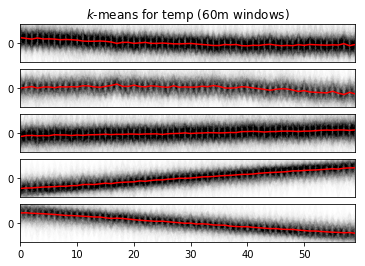

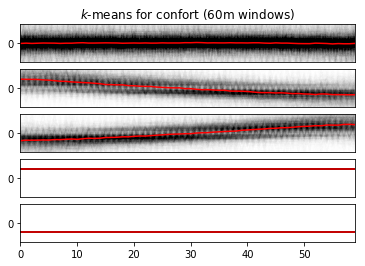

In [64]:
%%capture --no-display
def plot_windows(df, nb_clusters=5, length=120):
    nb_features = df.shape[1]
    df_copy = df.copy()
    # Group by length quanta-of-time windows.
    windows = df.groupby(df_copy['time'] // length * length)
    ts_set = []
    means_all = df.mean()
    
    for key, window in windows:

        # Only take the series where all observations are present.
        if len(window) == length:
            means = {window.columns[i]: means_all[i] if np.all(np.isnan(window.iloc[:,i])) else window.iloc[:,i].mean() for i in range(1, nb_features)}
            #print(means)
            if not 0 == np.sum(np.isnan(window.iloc[:,1:].fillna(means).values)):
                print(key, window, means)
            ts_set.append(window.iloc[:,1:].fillna(means).values)
    # Make a TS dataset out of the data. (order 3 tensor)                
    TS = to_time_series_dataset(ts_set)
    print("TS.shape :", TS.shape)
    print(np.isnan(TS).any(axis=2).sum(), "rows with nan.")

    # Instantiate a scaler (mean=0, variance=1) and transform the data.
    # Necessary because of euclidian-distance k-means.
    scaler = TimeSeriesScalerMeanVariance()
    X = scaler.fit_transform(TS)
    #X = TS
    nb_features = X.shape[2]

    # Plot kmeans clusters for each sensor time series.
    plt.figure()
    for i in range(nb_features):
        # Select the column for the i-th sensor.
        X_train = X[:,:,i]

        kmeans = TimeSeriesKMeans().fit(X_train)

        km = TimeSeriesKMeans(n_clusters=nb_clusters)
        y_pred = km.fit_predict(X_train)

        sz = X_train.shape[1]-1
        # Plot each cluster.
        for yi in range(nb_clusters):
            plt.subplot(nb_clusters, 1, yi + 1)

            # Plot the time series assigned to the cluster.
            for xx in X_train[y_pred == yi]:
                plt.plot(xx.ravel(), "k-", alpha=.005)
            # Plot the centroid.
            plt.plot(km.cluster_centers_[yi].ravel(), "r-")

            plt.xlim(0, sz)
            plt.ylim(-2, 2)
            if yi == 0:
                plt.title("$k$-means for "+str(df.columns[i+1])+" ("+str(length)+"m windows)")
            # Disable the x axis ticks to not clutter the figure.
            if yi != nb_clusters-1:
                plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            #Only plot the 0 (center) tick for the y axis.
            plt.yticks([0])
        plt.show()
 
plot_windows(df, 5, 60)

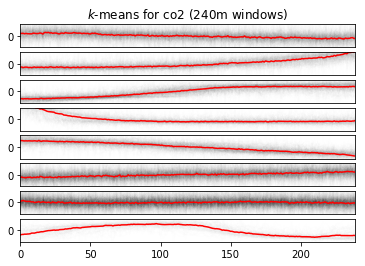

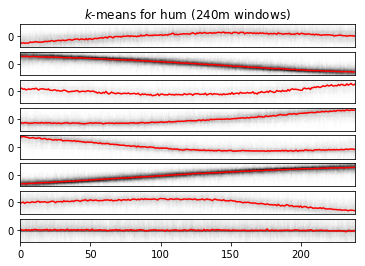

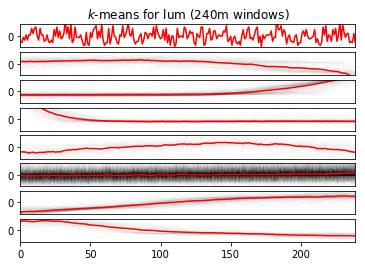

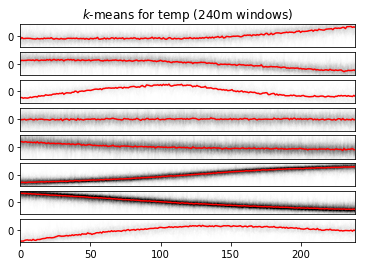

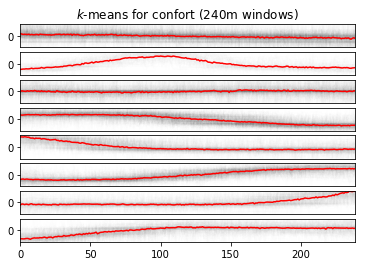

In [65]:
%%capture --no-display

# Same thing, but with 4 hour windows and 8 clusters.
plot_windows(df, 8, 60*4)

### Paires de variables

Ce graphique présente les couples de variables que l'on graphe avec une fonction particulière. On trouve un affichage des points du couple, de l'histogramme si ce couple est une seule variable, et d'une estimation de la fonction de densité de probabilité. Les couleurs correspondent au confort, que l'on a ramené à des valeurs entières ici pour un meilleur affichage. Cette matrice est symétrique.

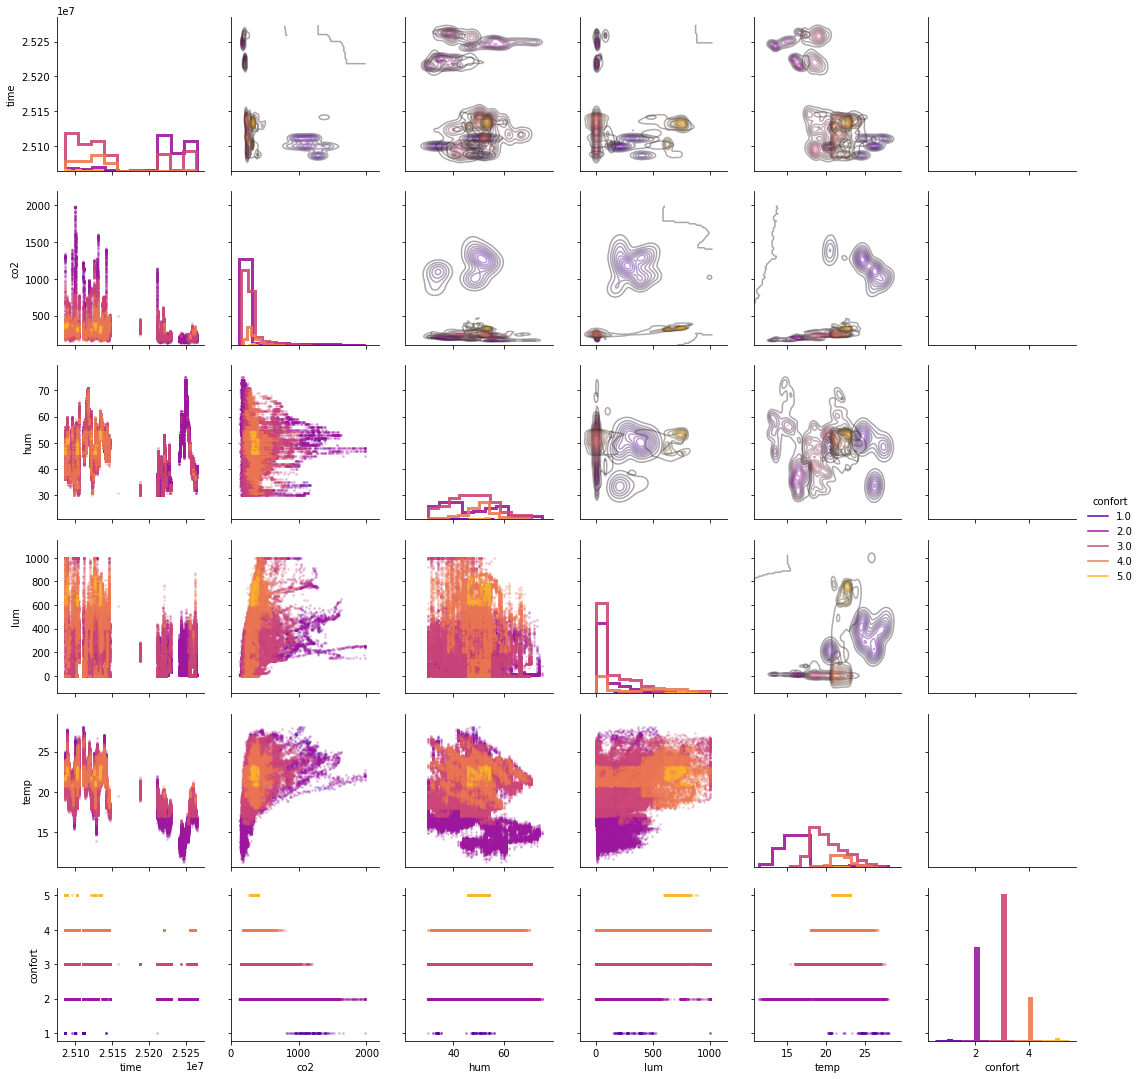

In [66]:
%%capture --no-display
def plot_pairs(df):
    df_copy = df.copy()
    
    # Quantize the confort column to get better plot colorization.
    df_copy['confort'] = np.floor(df['confort']) # /5 to normalize

    # Create a grid where columns are compared pair-wise.
    # Colors of "plotted stuff" depends on the value of the confort column.
    g = sns.PairGrid(df_copy, hue='confort', palette="plasma")

    # Plot scatter, histogram and density estimation plots.
    g = g.map_lower(plt.scatter, s=3, alpha=0.2)
    g = g.map_diag(plt.hist, histtype='step', linewidth=3, alpha=0.9)
    g = g.map_upper(sns.kdeplot, alpha=0.4, legend=False)
    g.add_legend()

    plt.show()

plot_pairs(df.iloc[:100000].dropna())